In [392]:
import requests
import math
import copy

class EyeBrow(object):
    """
    眉毛模型
    """

    # clockwise cord names
    __attrs__ = (
        'left_eyebrow_left_corner',
        'left_eyebrow_lower_left_quarter',
        'left_eyebrow_lower_middle',
        'left_eyebrow_lower_right_quarter',
        'left_eyebrow_right_corner',
        'left_eyebrow_upper_right_quarter',
        'left_eyebrow_upper_middle',
        'left_eyebrow_upper_left_quarter',
    )

    def __init__(self, **kwargs):
        for attr in self.__attrs__:
            setattr(self, attr, kwargs[attr])

    def corner_upper_middle_angle(self):
        """
        upper middler: B as origin
        left corner: A
        right corner: C
        """
        BA = [
            self.left_eyebrow_left_corner['x'] - self.left_eyebrow_upper_middle['x'],
            self.left_eyebrow_left_corner['y'] - self.left_eyebrow_upper_middle['y']
        ]
        
        BC = [
            self.left_eyebrow_right_corner['x'] - self.left_eyebrow_upper_middle['x'],
            self.left_eyebrow_right_corner['y'] - self.left_eyebrow_upper_middle['y']
        ]
        
        cosin = (BA[0] * BC[0] + BA[1] * BC[1]) / (math.sqrt(BA[0]**2 + BA[1]**2) * math.sqrt(BC[0]**2) + BC[1]**2)
        return cosin

    def left_corner_up_left_q_right_corner_ratio(self):
        """右角到上眉峰 占据 整个眉长的比例."""
        a = abs(self.left_eyebrow_right_corner['x'] - self.left_eyebrow_left_corner['x'])
        b = abs(self.left_eyebrow_right_corner['x'] - self.left_eyebrow_upper_left_quarter['x'])
        return b / a

    def left_right_corner_rand(self):
        """眉毛角点 右上q点 夹角 atan2."""
        x = self.left_eyebrow_right_corner['x'] - self.left_eyebrow_upper_middle['x']
        y = self.left_eyebrow_right_corner['y'] - self.left_eyebrow_upper_middle['y']
        return math.atan2(y, x)
    
    def right_corner_upper_q_rand(self):
        x = self.left_eyebrow_upper_right_quarter['x'] - self.left_eyebrow_upper_left_quarter['x']
        y = self.left_eyebrow_upper_right_quarter['y'] - self.left_eyebrow_upper_left_quarter['y']
        return 1
        # return math.atan2(y, x)
    
    def get_vector(self):
        return [
            self.corner_upper_middle_angle(),
            self.left_corner_up_left_q_right_corner_ratio(),
            self.left_right_corner_rand(),
            self.right_corner_upper_q_rand(),
        ]


class Face(object):
    url = 'https://api-cn.faceplusplus.com/facepp/v3/detect'

    def __init__(self, image_file=None):
        self.image_file = image_file
        self.landmark = None
        self.roll_rand = None
        self.eye = None

    def detect_face(self):
        response = requests.post(
            self.url,
            files={'image_file': open(self.image_file, 'rb')},
            data={
                'api_key': 'uA0f3Shnn2nt1GxmIPwJNsrP28PdtygU',
                'api_secret': 'YFCmCn9LyIb9dIZl2Mb5-C1z1spIPMbm',
                'return_landmark': '1',
                'return_attributes': 'headpose'}
        )
        
        if response.status_code == 200:
            content = response.json()
            faces = content['faces']
            if faces:
                face = faces[0]
                self.landmark = face['landmark']
                roll_angle = face['attributes']['headpose']['roll_angle']
                self.roll_rand = math.pi / 180 * roll_angle
        else:
            raise Exception

In [393]:
import glob
from IPython.display import Image, display


def get_features(trainset_dirpath):
    files = glob.glob(trainset_dirpath)
    result = []
    for file_name in files[:10]:
        f = Face(file_name)
        f.detect_face()
        eyebrow = EyeBrow(**f.landmark)
        v = eyebrow.get_vector()
        result.append(v)
    return result

In [394]:
pingzhis = get_features('/Users/pengfei/Code/ipython_notebook/notes/facedetect/trainsets/eyebrow/pingzhi/*')
print('pingzhi')

xiachuis = get_features('/Users/pengfei/Code/ipython_notebook/notes/facedetect/trainsets/eyebrow/xiachui/*')
print('xiachui')

gongxings = get_features('/Users/pengfei/Code/ipython_notebook/notes/facedetect/trainsets/eyebrow/gongxing/*')
print('gongxing')

liuyes = get_features('/Users/pengfei/Code/ipython_notebook/notes/facedetect/trainsets/eyebrow/liuye/*')
print('liuyes')

shangtiaos = get_features('/Users/pengfei/Code/ipython_notebook/notes/facedetect/trainsets/eyebrow/shangtiao/*')
print('shangtiaos')

pingzhi
xiachui
gongxing
liuyes
shangtiaos


In [395]:
Xs = pingzhis + xiachuis + gongxings + liuyes + shangtiaos
Ys = ['pingzhi'] * len(pingzhis) + ['xiachui'] * len(xiachuis) + ['gongxing'] * len(gongxings) + ['liuye'] * len(liuyes) + ['shangtiao'] * len(shangtiaos)

from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(Xs, Ys)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [396]:
def get_vertor(file_path): 
    f = Face(file_path)
    f.detect_face()
    eyebrow = EyeBrow(**f.landmark)
    return eyebrow.get_vector()

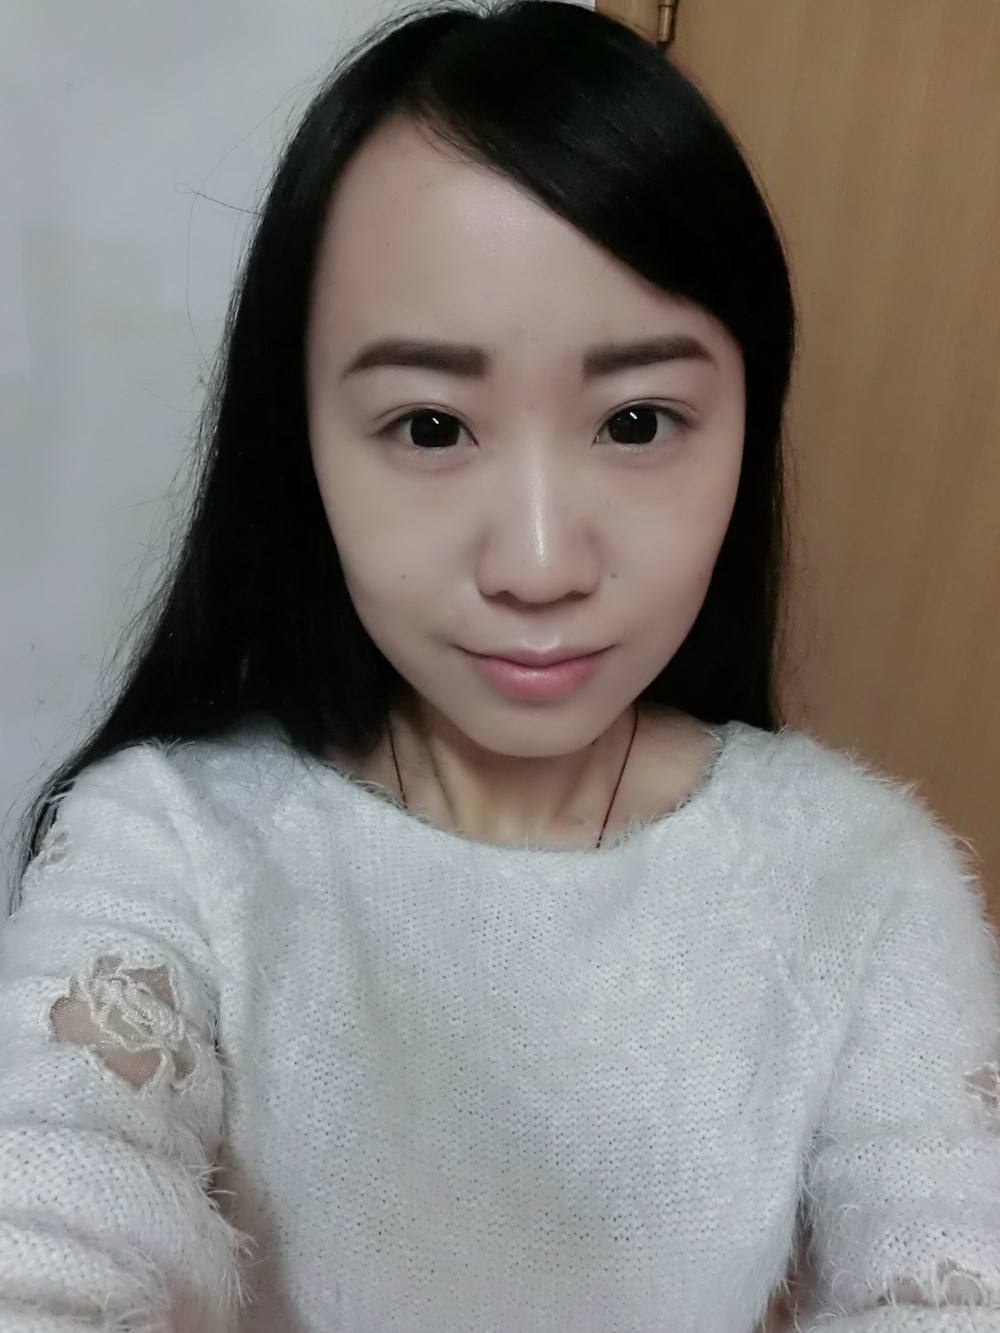

[-0.6013614706357525, 0.7972972972972973, 0.38931672183314087, 1]
liuye


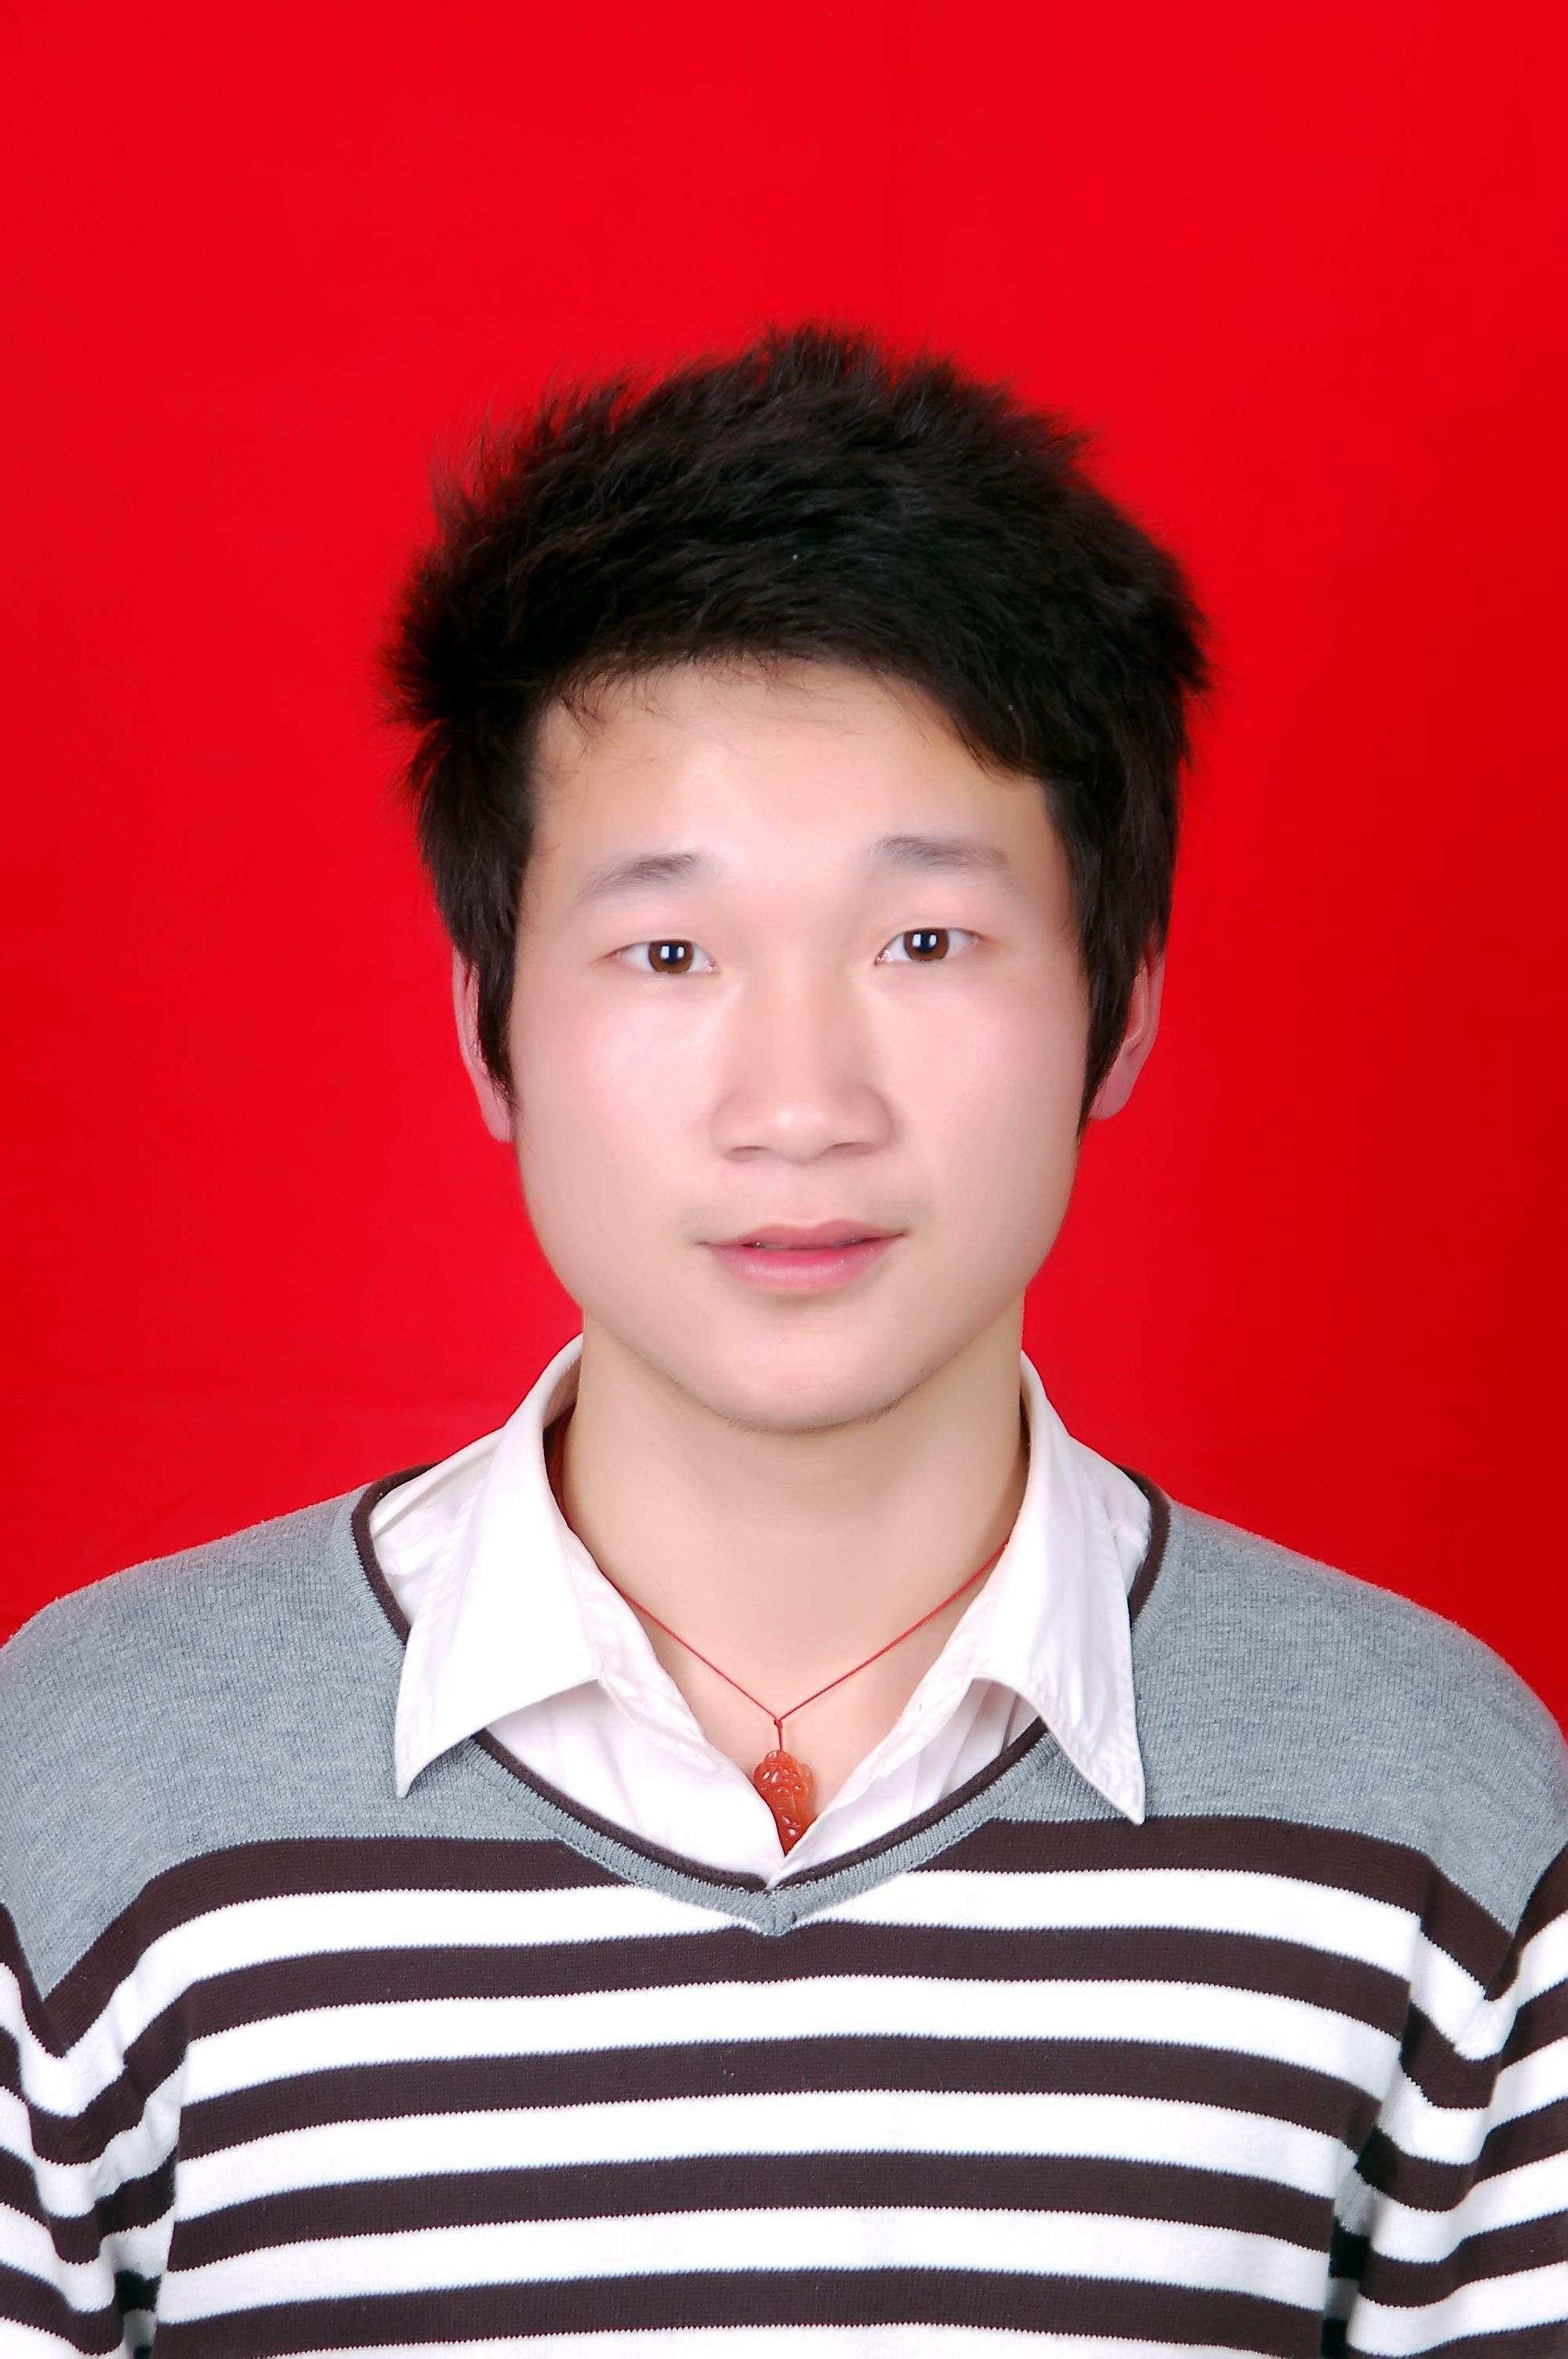

['pingzhi']


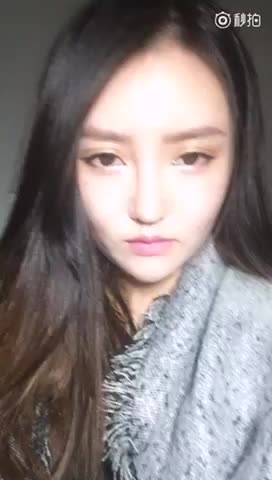

['shangtiao']
[-0.6024653475127002, 0.7777777777777778, 0.4636476090008061, 1]


In [403]:
from IPython.display import Image,display

fn = '/Users/pengfei/Code/ipython_notebook/notes/facedetect/testsets/pingzhi-01.jpeg'
display(Image(filename=fn))
v = get_vertor(fn)
print(v)
print(neigh.predict([v])[0])


fn = '/Users/pengfei/Code/ipython_notebook/notes/facedetect/testsets/xiachui-01.jpeg'
display(Image(filename=fn))
v = get_vertor(fn)
print(neigh.predict([v]))

fn = '/Users/pengfei/Code/ipython_notebook/notes/facedetect/testsets/shangtiao-01.jpg'
display(Image(filename=fn))
v = get_vertor(fn)
print(neigh.predict([v]))
print(v)

In [398]:
from sklearn import svm

clf = svm.SVC()
clf.fit(Xs, Ys)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

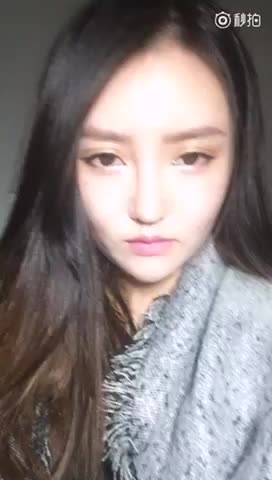

[-0.6644437413904002, 0.7678571428571429, 0.4636476090008061, 1]
['pingzhi']


In [400]:
fn = '/Users/pengfei/Code/ipython_notebook/notes/facedetect/testsets/shangtiao-01.jpg'
display(Image(filename=fn))
v = get_vertor(fn)
print(v)
print(clf.predict([v]))